In [34]:
import timecorr as tc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import hypertools as hyp
import os
from scipy.special import gamma
from scipy import signal
import seaborn as sns

%matplotlib inline

In [35]:
TINY_SIZE = 10
SMALL_SIZE = 18
MEDIUM_SIZE = 21
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('legend', loc='lower left')
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')

In [36]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [37]:
nT = 10 #number of timepoints
K = 10 #precision of temporal reconstructions (order of derivatives)
dt = 0.001 #temporal resolution

N = 50 #number of time cells
N_buffered = N + 2*K #number of time cells in intermediate layer, accounting for additional cells needed to compute derivatives

taustar_min = 1 #peak time of first time cell
taustar_max = nT #peak time of last time cell

#use a distribution of power law scaled time cell peaks
alpha = (taustar_max / taustar_min) ** (1/N) - 1 #scaling parameter
taustars = np.power(taustar_min * (1 + alpha), np.arange(-K, N+K)) #time cell peaks
s = np.divide(K, taustars) #integration parameters (Shankar and Howard 2012, eqn. 2.3)

#time vectora
taus = np.arange(0, nT + dt, dt)

In [38]:
s[K:-K]

array([10.        ,  9.54992586,  9.12010839,  8.7096359 ,  8.31763771,
        7.94328235,  7.58577575,  7.2443596 ,  6.91830971,  6.60693448,
        6.30957344,  6.02559586,  5.75439937,  5.49540874,  5.2480746 ,
        5.01187234,  4.78630092,  4.5708819 ,  4.36515832,  4.16869383,
        3.98107171,  3.80189396,  3.63078055,  3.4673685 ,  3.31131121,
        3.16227766,  3.01995172,  2.8840315 ,  2.7542287 ,  2.63026799,
        2.51188643,  2.39883292,  2.29086765,  2.18776162,  2.08929613,
        1.99526231,  1.90546072,  1.81970086,  1.73780083,  1.65958691,
        1.58489319,  1.51356125,  1.44543977,  1.38038426,  1.31825674,
        1.25892541,  1.20226443,  1.14815362,  1.0964782 ,  1.04712855])

In [39]:
def derivative_matrix(N, s):
    D = np.zeros([N, N])
    for i in np.arange(0, N-2):
        D[i+1, i] = -(s[i+2] - s[i+1]) / (s[i+1] - s[i]) / (s[i+2] - s[i])
        D[i+1, i+1] = ((s[i+2] - s[i+1]) / (s[i+1] - s[i]) - (s[i+1] - s[i]) / (s[i+2] - s[i+1])) / (s[i+2] - s[i])
        D[i+1, i+2] = (s[i+1] - s[i]) / (s[i+2] - s[i+1]) / (s[i+2] - s[i])
    return D

In [40]:
def btwn(x, a, b):
    return (x >= a) & (x <= b)

In [41]:
fact = lambda x: gamma(x+1)

In [42]:
def get_tT(taus, f, s, K):
    N = len(s)
    nT = len(f)
    
    t = np.zeros([N, nT])
    T = np.zeros([N, nT])
    
    D = derivative_matrix(N, s)
    
    for i in np.arange(1, len(taus)):
        t[:, i] = t[:, i-1] + np.multiply(np.multiply(-s.T, t[:, i-1]) + f[i], taus[i] - taus[i-1])
        t_diff = np.dot(np.linalg.matrix_power(D, K), t[:, i])
        T[:, i] = np.multiply(np.power(-1, K), np.power(s.T, K+1)) * np.divide(t_diff, fact(K))
    return t, T

In [43]:
def plot_timecourse(taus, taustars, f, s, K, fname=None):
    t, T = get_tT(taus, f, s, K)
    
    t = np.divide(t, np.max(t[K:-K, :]))
    T = np.divide(T, np.max(T[K:-K, :]))
    
    plt.figure(figsize=(8.5,3))
    colors = sns.cubehelix_palette(n_colors=t.shape[0] - 2*K)        
    for i in np.arange(K, t.shape[0]-K-1):
        plt.plot(taus, t[i, :], c=colors[i - K])
    
    plt.plot(taus, f, 'k', linewidth=2)
    plt.plot(np.max(taus) - taustars[K:-K], T[K:-K, -1] / np.max(T[K:-K, -1]), c=(0.5, 0.5, 0.5), linewidth=2)
    plt.xlim([np.min(taus), np.max(taus)])
    plt.xlabel('Time')
    plt.ylabel('Activation')
    
    if not (fname == None):
        plt.gcf().savefig(fname)
    
    return t, T

In [44]:
def plot_layer(xs, ys, vals, xlabel, ylabel):
    df = pd.DataFrame(vals, index=ys, columns=xs)
    
    #xres = 5
    #yres = 5
    #xticks = df.columns.values[0:-1:int(np.round(len(df.columns)/xres))]
    #yticks = df.columns.values[0:-1:int(np.round(len(df.columns)/yres))]
    
    ax = sns.heatmap(df)#, xticklabels=xticks.round(0), yticklabels=yticks.round(1))
    #xformatter = FormatStrFormatter('%d')
    #yformatter = FormatStrFormatter('%0.1f')
    #ax.xaxis.set_major_formatter(xformatter)
    #ax.yaxis.set_major_formatter(yformatter)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return ax

In [45]:
f = np.zeros(len(taus))
f[btwn(taus, 2, 2.5)] = 1
f[btwn(taus, 8, 8.75)] = 1

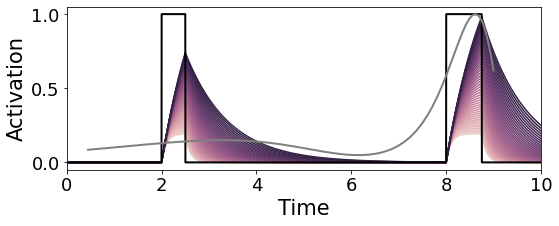

In [46]:
t, T = plot_timecourse(taus, taustars, f, s, K)

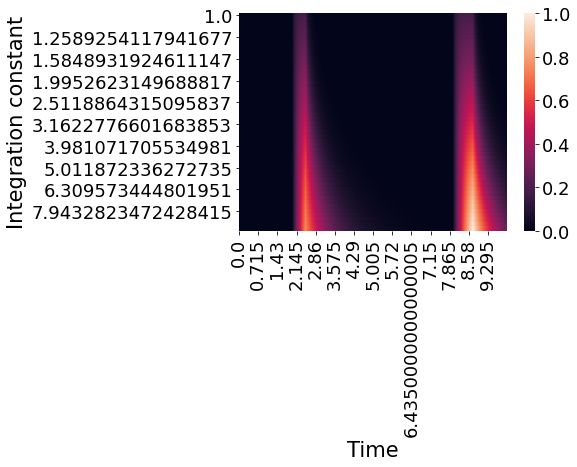

In [47]:
plot_layer(taus, taustars[K:-K], t[K:-K, :], 'Time', 'Integration constant')

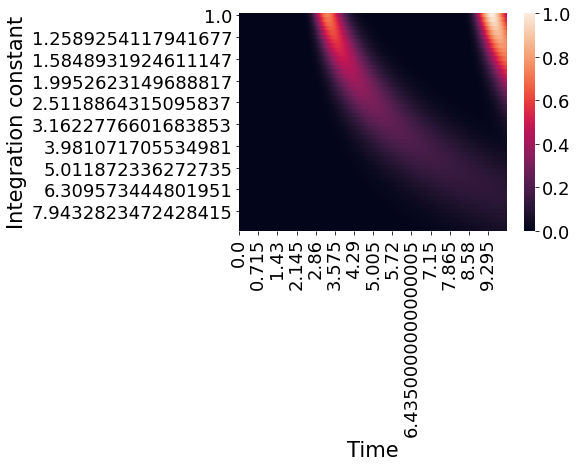

In [48]:
plot_layer(taus, taustars[K:-K], T[K:-K, :], 'Time', 'Integration constant')

In [111]:
sos = signal.butter(2, 4, 'lp', fs=1000, output='sos')

f = np.cumsum(np.random.randn(len(taus)))
f = signal.sosfilt(sos, f)

f = f - np.min(f)
f = f / np.max(f)

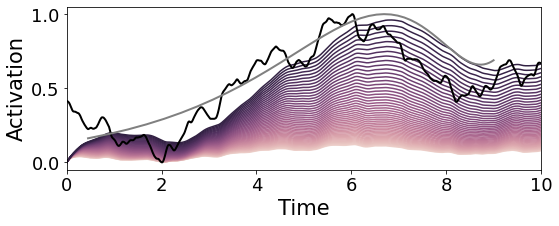

In [112]:
t, T = plot_timecourse(taus, taustars, f, s, K, os.path.join(figdir, 'drift_random.pdf'))

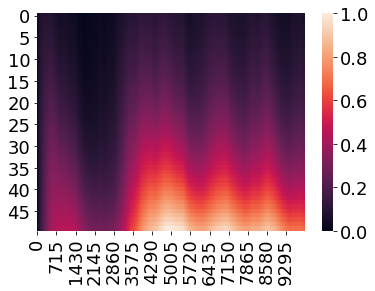

In [22]:
sns.heatmap(t[K:-K, :])

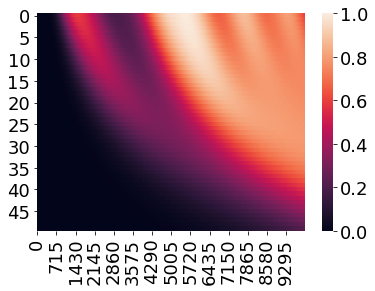

In [23]:
sns.heatmap(T[K:-K, :])

In [28]:
ts = np.arange(len(taus))

N_events = 5 #number of events
events = np.random.choice(ts, N_events, replace=False)

x = np.zeros(ts.shape)
durations = np.random.poisson(2*len(ts)/(N_events**2), N_events)

for i, t in enumerate(events):
    x[t:(t+durations[i])] = 1

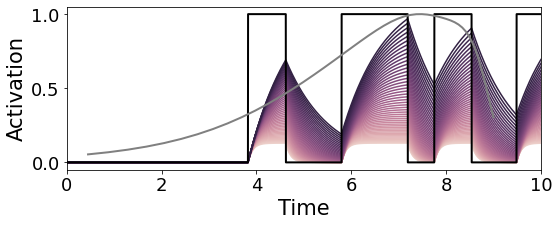

In [29]:
t, T = plot_timecourse(taus, taustars, x, s, K, os.path.join(figdir, 'drift_block.pdf'))